In [33]:
import torch

from pathlib import Path

In [35]:
run_path = Path("runs/gradient_correlation_length")

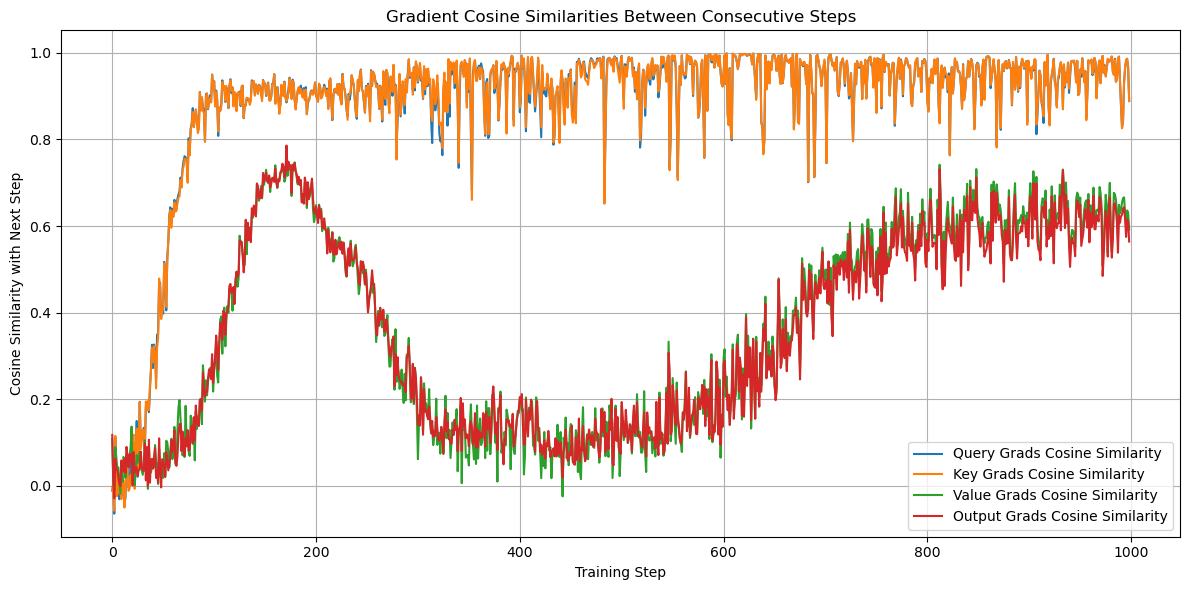

In [36]:
import os
import torch
import glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torch.nn.functional import cosine_similarity

# Define the path to the run directory
run_name = "gradient_correlation_length"
run_dir = Path("runs") / run_name

# List all checkpoint files
checkpoint_files = sorted(run_dir.glob("step_*.pth"), key=lambda x: int(x.stem.split('_')[1]))

# Initialize lists to store gradients
query_grads = []
key_grads = []
value_grads = []
output_grads = []

# Load gradients from each checkpoint
for checkpoint_file in checkpoint_files:
    checkpoint = torch.load(checkpoint_file)
    query_grad = checkpoint['query_grad'].flatten()
    key_grad = checkpoint['key_grad'].flatten()
    value_grad = checkpoint['value_grad'].flatten()
    output_grad = checkpoint['output_grad'].flatten()

    query_grads.append(query_grad)
    key_grads.append(key_grad)
    value_grads.append(value_grad)
    output_grads.append(output_grad)

# Stack gradients into tensors
query_grads = torch.stack(query_grads)
key_grads = torch.stack(key_grads)
value_grads = torch.stack(value_grads)
output_grads = torch.stack(output_grads)

# Compute cosine similarity between consecutive gradients
def compute_cosine_similarities(gradients):
    similarities = []
    for i in range(len(gradients) - 1):
        cos_sim = cosine_similarity(gradients[i], gradients[i + 1], dim=0)
        similarities.append(cos_sim.item())
    return similarities

query_similarities = compute_cosine_similarities(query_grads)
key_similarities = compute_cosine_similarities(key_grads)
value_similarities = compute_cosine_similarities(value_grads)
output_similarities = compute_cosine_similarities(output_grads)

# Plotting the cosine similarities
steps = [int(f.stem.split('_')[1]) for f in checkpoint_files[:-1]]  # Exclude the last step for plotting

plt.figure(figsize=(12, 6))
plt.plot(steps, query_similarities, label='Query Grads Cosine Similarity')
plt.plot(steps, key_similarities, label='Key Grads Cosine Similarity')
plt.plot(steps, value_similarities, label='Value Grads Cosine Similarity')
plt.plot(steps, output_similarities, label='Output Grads Cosine Similarity')
plt.xlabel('Training Step')
plt.ylabel('Cosine Similarity with Next Step')
plt.title('Gradient Cosine Similarities Between Consecutive Steps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()